In [1]:
"""
패션 MNIST 데이터 불러오기

(48000, 28, 28 )크기인 train_input이 (48000, 28, 28, 1) 크기인 train_scaled가 되었다
"""
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
train_scaled, train_target, test_size=0.2, random_state=42)

In [2]:
print(train_target.shape)

(48000,)


In [3]:
print(train_scaled.shape)

(48000, 28, 28, 1)


In [4]:
"""
- 합성곱 신경망 만들기
케라스의 Sequential 클래스를 사용해 순서대로 이 구조를 정의

먼저 Sequential 클래스의 객체를 만들고 첫 번째 합성곱 층인 Conv2D를 추가함
add()메서드를 사용해 층을 하나씩 차례대로 추가

합성곱 층은 32개의 필터를 사용함
커널의 크기는 (3, 3)이고 
렐루 활성화 함수와 세임 패딩을 사용


"""
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation="relu", padding="same",
                             input_shape=(28, 28, 1)))

In [5]:
"""
풀링층 추가 
케라스는 최대 풀링과 평균 풀링을 keras.layers 패키지 아래 
MaxPooling2D와 AveragePooling2D 클래스로 제공
전형적인 풀링 크기인 (2,2) 풀링을 사용
가로세로 크기가 같으면 정수 하나로 지정할수 있다
"""
model.add(keras.layers.MaxPooling2D(2))

In [6]:
"""
패션 MNIST 이미지가 (28, 28) 크기에 세임 패딩을 적용했기 때문에 
합성곱 층에서 출력된 특성 맵의 가로세로 크기는 입력과 동일함
그 다음 (2, 2)풀링을 적용했으므로 특성 맵의 크기는 절반으로 줄어듬 
합성곱 층에서 32개의 필터를 사용했기 때문에 특성 맵의 깊이는 32가 됨
따라서 최대 풀링을 통과한 특성 맵의 크기는 (14, 14, 32) 가 됨
각 층의 출력 크기를 summary()메서드로 확인

첫 번째 합성곱-풀링 층 다음에 두 번째 합성곱-풀링 층을 추가해 보겠습니다
두 번째 합성곱-풀링 층은 첫 번째와 거의 동일
필터의 개수를 64개로 늘린 점만 다름
"""
model.add(keras.layers.Conv2D(64, kernel_size=3, activation="relu", padding="same"))
model.add(keras.layers.MaxPooling2D(2))

In [7]:
"""
최종적으로 만들어지는 특성 맵의 크기는 (7, 7, 64)가 됨

이 3차원 특성 맵을 일렬로 펼칠차례
이렇게 하는 이유는 마지막에 10개의 뉴런을 가진 출력층에서 확률을 계산하기 때문
여기에서는 특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고
중간에 하나의 밀집 은닉층을 하나 더 둠
즉 Flatten 클래스 다음에 Dense 은닉층, 마지막으로 Dense 출력층의 순서
"""
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation="softmax"))

In [8]:
"""
은닉층과 출력층 사이에 드롭아웃을 넣음
드롭아웃 층이 은닉층의 과대적합을 막아 성능을 조금 더 개선해 줄 것
은닉층은 100개의 뉴런을 사용하고 활성화 함수는 합성곱 층과 마찬가지로 
렐루 함수를 사용함
패션 MNIST 데이터셋은 클래스 10개를 분류하는 다중 분류 문제이므로 마지막 층의 활성화 함수는 소프트맥스를 사용

모델 구조를 출력 summary()
"""
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

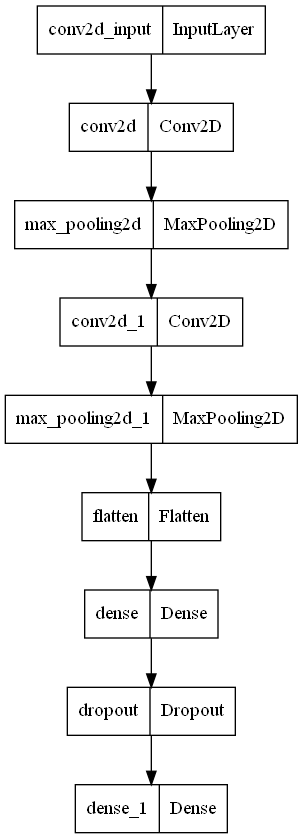

In [9]:
"""
summary()메서드의 출력 결과를 보면 합성곱 층과 풀링 층의 효과가 잘 나타나 있다
첫번째 합성곱 층을 통과하면서 특성 맵의 깊이는 32가 되고 
두번째 합성곱에서 특성 맵의 크기가 64로 늘어남
반면 특성 맵의 가로세로 크기는 첫 번째 풀링 층에서 절반으로 줄어들고 
두 번째 풀링층에서 다시 절반으로 더 줄어듬
따라서 최종 특성 맵의 크기는 (7, 7, 64)

첫 번째 합성곱층은 320개의 파라미터
두 번째 합성곱층은 18496개의 파라미터
은닉층의 모델 파라미터 개수는 313700개 
마지막 출력층의 모델 파라미터 개수는 1010개

모델을 그림으로 표현해 주는 plot_model() 함수를 keras.utils 패키지에서 제공
"""
keras.utils.plot_model(model)

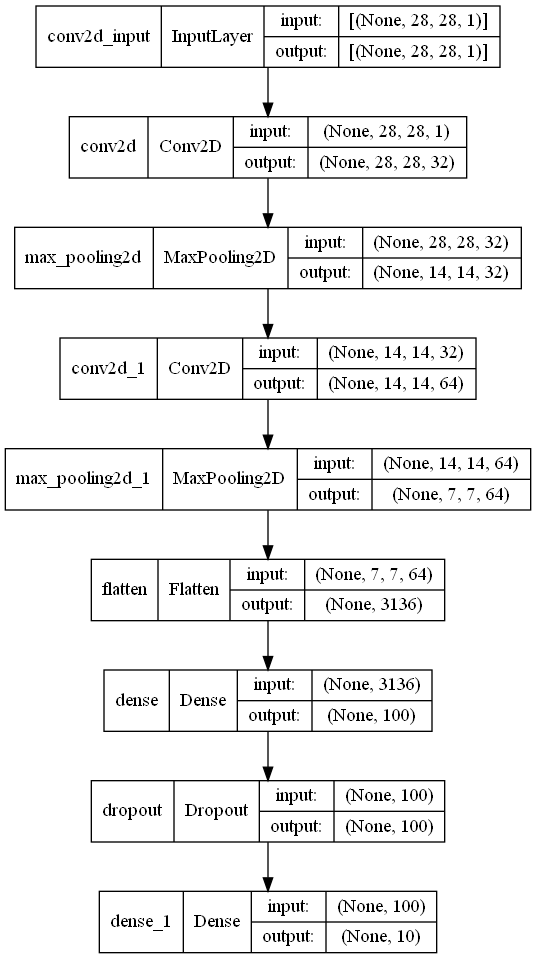

In [10]:
"""
plot_model()함수의 show_shapes 매개변수를 True 설정하면 
이 그림에 입력과 출력의 크기를 표시해줌

"""
keras.utils.plot_model(model, show_shapes=True)

In [13]:
"""
- 모델 컴파일과 훈련
Adam 옵티마이저를 사용하고 ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용해 조기 종료 기법 구현
"""
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-cnn-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target),
                   callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 13s 4ms/step - loss: 0.5225 - accuracy: 0.8117 - val_loss: 0.3255 - val_accuracy: 0.8774
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3446 - accuracy: 0.8759 - val_loss: 0.2835 - val_accuracy: 0.8963
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2970 - accuracy: 0.8933 - val_loss: 0.2612 - val_accuracy: 0.9054
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2617 - accuracy: 0.9047 - val_loss: 0.2466 - val_accuracy: 0.9089
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2400 - accuracy: 0.9121 - val_loss: 0.2292 - val_accuracy: 0.9161
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2182 - accuracy: 0.9197 - val_loss: 0.2240 - val_accuracy: 0.9180
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2043 - accuracy: 0.9243 - val_loss: 0.2256 - val_accuracy

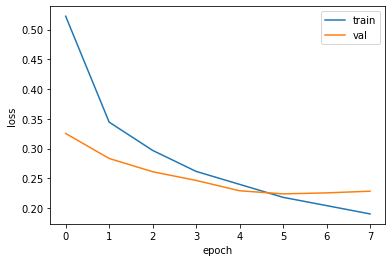

In [14]:
"""
손실 그래프를 그려서 조기 종료가 잘 이루어졌는지 확인
"""
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

In [15]:
"""
EarlyStopping 클래스에서 restore_best_weights 매개변수를 True로 지정했으므로 
현재 model 객체가 최적의 모델 파라미터로 복원 되어 있다
즉 ModelCheckpoint 콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없다
이번에는 세트에 대한 성능을 평가
"""
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2240 - accuracy: 0.9180


[0.22397339344024658, 0.9179999828338623]

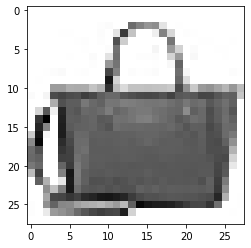

In [16]:
"""
predict() 메서드를 사용해 훈련된 모델을 사용하여 새로운 데이터에 대해 예측

첫 번째 샘플을 가지고 예측 테스트
맷플로립을로 흑백이미지에 깊이 차원은 없다 따라서(28, 28, 1) 크기를 (28, 28)로 바꾸어서 출력
"""
plt.imshow(val_scaled[0].reshape(28, 28), cmap="gray_r")
plt.show()

In [17]:
"""
predict() 메서드로 10개의 클래스에 대한 예측 확률을 출력
"""
preds = model.predict(val_scaled[0:1])
print(preds)

[[2.0244660e-17 3.4033660e-24 3.4628338e-17 3.0479058e-18 3.1405118e-16
  3.8824529e-17 3.6474380e-16 7.4607107e-16 1.0000000e+00 4.8197858e-18]]


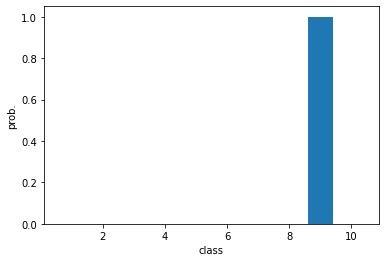

In [18]:
"""
아홉 번째 클래스라고 표시됨 
막대 그래프로 그려봄
"""
plt.bar(range(1, 11), preds[0])
plt.xlabel("class")
plt.ylabel("prob.")
plt.show()

In [19]:
"""
패선 MNIST 데이터셋의 레이블로 확인
파이썬에서 레이블을 다루기 위해 리스트로 저장
"""
classes = ["티셔츠", "바지", "스웨터", "드레스", "코트", "샌달", "셔츠", "스니커즈", "가방", "앵클 부츠"]

In [20]:
"""
preds 배열에서 가장 큰 인덱스를 찾아 classes 리스트의 인덱스로 활용
"""
import numpy as np
print(classes[np.argmax(preds)])

가방


In [21]:
"""
테스트 세트로 합성곱 신경망의 일반화 성능을 가늠해 봄
이 모델을 실전에 투입했을 때 얻을 수 있는 예상 성능
훈련 세트와 검증 세트에서 했던 것처럼 픽셀값의 범위를 0~1 사이로 바꾸고 
이미지 크기를 (28, 28)에서 (28, 28, 1)로 바꿈
"""
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [22]:
"""
evaluate()메서드로 테스트 세트에 대한 성능을 측정
"""
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 4ms/step - loss: 0.2451 - accuracy: 0.9110


[0.24511444568634033, 0.9110000133514404]